# dimensionality reduction methods (Chemical space analysis of small molecule drugs with RDKit)
The code is based on [oringial-code](https://github.com/rdkit/rdkit-tutorials/blob/master/notebooks/005_Chemical_space_analysis_and_visualization.ipynb) which last updated in 2017 and the purpose of it is to learn:

  - [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) - Principal component analysis

  - [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) - t-Distributed Stochastic Neighbor Embedding
  
Compared to original notebook, the file only: 

  - Update the depricated code that inconsistent with updated RDkit package

  - Annotate the code to add explaination or analysis tips

  - Add 2 new features:
    - PCA loading

    - PCA explained variance plot

In [1]:
from __future__ import print_function

# %matplotlib inline # this line is necessary for the plot to appear without plt.show()

In [2]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

Load the table of drugs (downloaded from [ChEMBL](https://www.ebi.ac.uk/chembl/) )

In [ ]:
df = pd.read_csv(
    "/Users/Joey/Workplace/MFH/Dimensionality_Reduction/Dataset/chembl_drugs.txt.gz", sep="\t"
)

Keep only compounds with SMILES, [USAN stems](https://www.ama-assn.org/about-us/united-states-adopted-names-approved-stems), that respect [Ro5](https://en.wikipedia.org/wiki/Lipinski's_rule_of_five) and are on the market

In [4]:
df = df[
    df["CANONICAL_SMILES"].notnull()  # Keep cpds with SMILES
    & df["USAN_STEM"].notnull()  # USAN stem
    & (df["RULE_OF_FIVE"] == "Y")  # that respect Ro5
    & (df["DEVELOPMENT_PHASE"] == 4)
]  # are on the market

In [5]:
len(df)

700

Add molecule column

In [6]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="CANONICAL_SMILES")
# Converts the molecules contains in “smilesCol” to RDKit molecules and appends them to "df" using with "ROMol"

In [7]:
df = df[~df["ROMol"].isnull()]  # remove where data is null in column "ROMol"

Check most common compound classees (based on USAN stem)

In [8]:
common_stems = df.groupby("USAN_STEM").size().sort_values()[-10:]
common_stems

USAN_STEM
-tinib     12
-olone     12
-pin(e)    12
-ium       14
-vir       15
-caine     15
-oxacin    17
-cillin    17
-olol      18
sulfa-     18
dtype: int64

In [9]:
stems = df.drop_duplicates(["USAN_STEM"])[
    df.drop_duplicates(["USAN_STEM"])["USAN_STEM"].isin(common_stems.index)
][["USAN_STEM", "USAN_STEM_DEFINITION"]]
stems.index = stems["USAN_STEM"]
stems["count"] = common_stems

In [10]:
stems.head()

,USAN_STEM,USAN_STEM_DEFINITION,count
USAN_STEM,,,
-olone,-olone,steroids (not prednisolone derivatives),12
-oxacin,-oxacin,antibacterials (quinolone derivatives),17
-pin(e),-pin(e),tricyclic compounds,12
-tinib,-tinib,tyrosine kinase inhibitors,12
-caine,-caine,local anesthetics,15


Helper functions

In [11]:
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator


def get_cfps(mol):
    morgan = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
    fp = morgan.GetFingerprint(mol)
    arr = np.zeros(
        (1,), dtype=np.int32
    )  # Return a new array of given shape and type, filled with zeros.
    DataStructs.ConvertToNumpyArray(fp, arr)  # Convert a 1024bits to a numpy array
    return arr

Calculate fingerprints

In [12]:
df["FP"] = df["ROMol"].map(get_cfps)

Extract compounds that belong to 10 most common USAN stems

In [13]:
df_small = df[df["USAN_STEM"].isin(list(stems.index))].copy()

### PCA analysis

In [14]:
from sklearn.decomposition import PCA

In [15]:
X = np.array([x for x in df_small["FP"]])

In [16]:
pca = PCA(n_components=3, random_state=0)
pca_drugs = pca.fit_transform(X)

#### PCA eigenvactors
direction of maximum variance, unit-scaled loadings

In [17]:
eigenvectors = pca.components_
pd.DataFrame(
    eigenvectors,
    columns=[f"Bit_{i+1}" for i in range(pca.components_.shape[1])],
    index=["PC1", "PC2", "PC3"],
).T

,PC1,PC2,PC3
Bit_1,0.005868,0.009528,0.003058
Bit_2,-0.051518,-0.092839,-0.131393
Bit_3,-0.000832,-0.013814,-0.021127
Bit_4,0.000481,0.005782,-0.005795
Bit_5,-0.114757,-0.022811,0.012771
...,...,...,...
Bit_1020,0.208287,-0.009992,-0.061757
Bit_1021,0.011904,-0.000586,-0.024308
Bit_1022,0.007408,0.017408,0.012781
Bit_1023,-0.000241,0.001894,-0.006825


#### Explained Variance
Amount of variance explained by each principal component. The first component explains the most variance, the second component explains the second most variance, and so on.

In [18]:
pd.DataFrame(
    {
        "Explained Variance": pca.explained_variance_,
        "Explained Variance Ratio": pca.explained_variance_ratio_,
    },
    index=["PC1", "PC2", "PC3"],
)

,Explained Variance,Explained Variance Ratio
PC1,2.727655,0.082611
PC2,2.390256,0.072393
PC3,1.721396,0.052135


In [19]:
# visualize the DataFrame with the explained variance
import matplotlib.pyplot as plt
import seaborn as sns

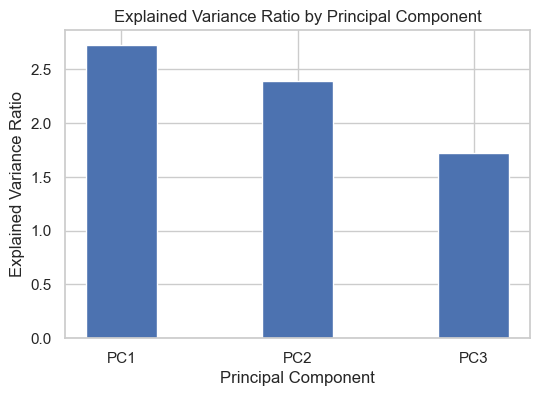

In [20]:
# Set the style of the visualization
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
# make the bar width smaller
plt.bar(x=["PC1", "PC2", "PC3"], height=pca.explained_variance_, width=0.4)

plt.title("Explained Variance Ratio by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.show()

The explained variance shows that the PC1 contributes the most to the variance in the data.

#### PCA Loading
Loadings represent the contribution of each original variable to the principal component.

They are used to understand patterns and relationships between variables and identify which variables contribute most to each of the Principal Components.

In [21]:
# Extract the loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings

array([[ 0.00969212,  0.01473069,  0.00401214],
       [-0.08508519, -0.14353403, -0.17239073],
       [-0.00137336, -0.02135739, -0.02771913],
       ...,
       [ 0.01223415,  0.02691322,  0.01676938],
       [-0.00039876,  0.002928  , -0.00895436],
       [ 0.01691705, -0.00895633, -0.00731362]], shape=(1024, 3))

In [22]:
# create a DataFrame with the loadings
loadings_df = pd.DataFrame(
    loadings,
    columns=["PC1", "PC2", "PC3"],
    index=[f"Bit_{i+1}" for i in range(loadings.shape[0])],
)

In [23]:
loadings_df_1 = loadings_df[["PC1", "PC2"]]
loadings_df_2 = loadings_df[["PC1", "PC3"]]
loadings_df_3 = loadings_df[["PC2", "PC3"]]

In [24]:
# Update as an interactive plot with ploty without making it into website
import plotly.graph_objects as go

# avoid openning a browser window
import plotly.io as pio

pio.renderers.default = (
    "notebook_connected"  # Use 'notebook_connected' for Jupyter Notebook
)

In [28]:
fig1 = go.Figure(
    data=go.Scatter(
        x=loadings_df_1["PC1"],
        y=loadings_df_1["PC2"],
        mode="markers",
        text=loadings_df_1.index,
        marker=dict(size=3, opacity=1),
    )
)
fig1.update_layout(
    title="PCA Loadings in 2D",
    xaxis_title="PC1",
    yaxis_title="PC2",
    width=800,
    height=400,
)
# also show the loadings_df_2 and loadings_df_3 by respectively creating new figures
fig2 = go.Figure(
    data=go.Scatter(
        x=loadings_df_2["PC1"],
        y=loadings_df_2["PC3"],
        mode="markers",
        text=loadings_df_2.index,
        marker=dict(size=3, opacity=1),
    )
)
fig2.update_layout(
    title="PCA Loadings in 2D (PC1 vs PC3)",
    xaxis_title="PC1",
    yaxis_title="PC3",
    width=800,
    height=400,
)
fig3 = go.Figure(
    data=go.Scatter(
        x=loadings_df_3["PC2"],
        y=loadings_df_3["PC3"],
        mode="markers",
        text=loadings_df_3.index,
        marker=dict(size=3, opacity=1),
    )
)
fig3.update_layout(
    title="PCA Loadings in 2D (PC2 vs PC3)",
    xaxis_title="PC2",
    yaxis_title="PC3",
    width=800,
    height=400,
)

# Show the figure
fig1.show()
fig2.show()
fig3.show()

Loadings Interpretation
 - Positive or negative: direction of the relationship
 - High absolute value: strong contribution to the component

Plot principal components

In [26]:
# remove the grid in the background
sns.set(style="white")

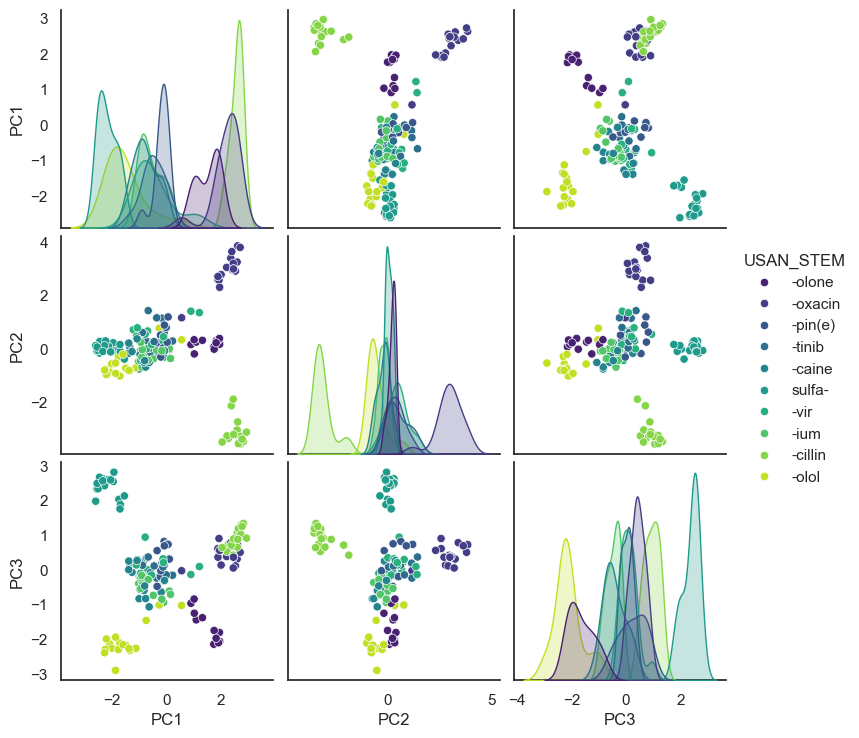

In [27]:
df_small["PC1"] = pca_drugs.T[0]  # T: Matrix transpose and pick up the first row
df_small["PC2"] = pca_drugs.T[1]
df_small["PC3"] = pca_drugs.T[2]
# doctest: IGNORE
sns.pairplot(
    df_small[["PC1", "PC2", "PC3", "USAN_STEM"]],
    hue="USAN_STEM",
    vars=["PC1", "PC2", "PC3"],
    palette="viridis",
)
# hue: color by USAN_STEM

### t-SNE
Note that [t-SNE is very sensitive to hyperparameter settings](http://distill.pub/2016/misread-tsne/).
#### Without PCA preprocessing

In [29]:
from sklearn.manifold import TSNE

In [30]:
model = TSNE(n_components=2, random_state=0, perplexity=30, max_iter=5000)
tsne_drugs = model.fit_transform(X)

In [31]:
df_small["TSNE_C1"] = tsne_drugs.T[0]
df_small["TSNE_C2"] = tsne_drugs.T[1]

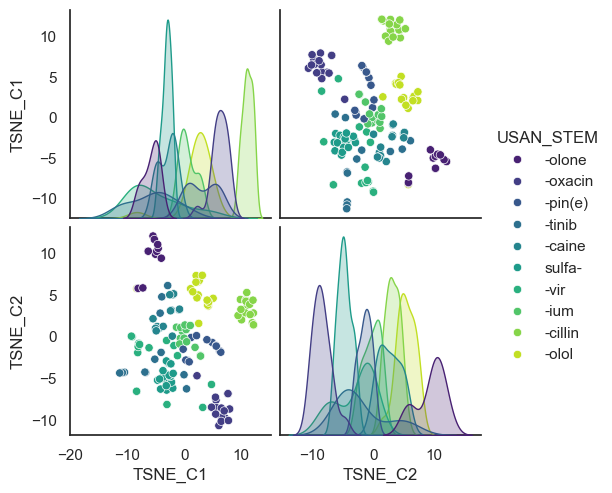

In [32]:
# doctest: IGNORE
sns.pairplot(
    df_small[["TSNE_C1", "TSNE_C2", "USAN_STEM"]],
    hue="USAN_STEM",
    vars=["TSNE_C1", "TSNE_C2"],
    palette="viridis",
)

#### With PCA preprocessing
In case of high dimensionality data (like molecular fingerprints) it is recommended to reduce the number of dimensions (e.g. PCA for dense data or TruncatedSVD for sparse data) with another method before proceeding with t-SNE. This will suppress some noise and speed up the computation of pairwise distances between samples. 

In [33]:
pca_model = PCA(n_components=30, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=30, max_iter=5000)
tsne_pca_drugs = tsne_model.fit_transform(pca_model.fit_transform(X))
# in tsne plot, the axes are not interpretable, but the distances between points are meaningful.
# In the same cluster, the closer the points are, the more similar they are, but this doesn't mean that the further between 2 clusters,
# the more different they are.

In [34]:
df_small["TSNE_PCA_C1"] = tsne_pca_drugs.T[0]
df_small["TSNE_PCA_C2"] = tsne_pca_drugs.T[1]

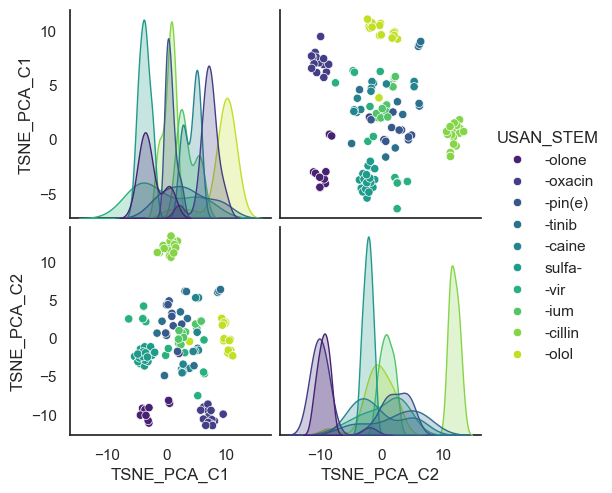

In [35]:
# doctest: IGNORE
sns.pairplot(
    df_small[["TSNE_PCA_C1", "TSNE_PCA_C2", "USAN_STEM"]],
    hue="USAN_STEM",
    vars=["TSNE_PCA_C1", "TSNE_PCA_C2"],
    palette="viridis",
)

Tutorial author: Samo Turk, Jan. 2017
Tutorial editor: Jiayi Ding, Jul. 2025

LINCENSE
This work is licensed under the Creative Commons Attribution-ShareAlike 4.0 License. To view a copy of this license, visit <http://creativecommons.org/licenses/by-sa/4.0/>.